In [32]:
# from torch.utils.data import Dataset, DataLoader
from torch.utils.data import DataLoader, Dataset
import torch
import glob
from PIL import Image
import numpy as np 
from tqdm import tqdm
from torchvision import transforms
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [33]:
if torch.cuda.is_available():
  device = torch.device("cuda:0")
  print("Cuda De|vice Available")
  print("Name of the Cuda Device: ", torch.cuda.get_device_name())
  print("GPU Computational Capablity: ", torch.cuda.get_device_capability())

Cuda De|vice Available
Name of the Cuda Device:  Tesla T4
GPU Computational Capablity:  (7, 5)


In [34]:
# class ToTensor(object):
#     """Convert ndarrays in sample to Tensors."""

#     def __call__(self, sample):
#         image, landmarks = sample['input'], sample['output']

#         # swap color axis because
#         # numpy image: H x W x C
#         # torch image: C X H X W
#         image = np.array(image).transpose((2, 0, 1))
#         # print(image.shape)
#         # print(torch.from_numpy(image).size())
#         return {'input': torch.from_numpy(image),
#                 'output': torch.from_numpy(np.array(landmarks))}

In [35]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, landmarks = sample['input'], sample['output']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = np.array(image).transpose((2, 0, 1))
        # print(image.shape)
        # print(torch.from_numpy(image).size())
        return {'input': torch.from_numpy(image),
                'output': torch.from_numpy(np.array(landmarks))}

In [36]:
class RockPapersDataset(Dataset):
  def __init__(self, data_path, mode, transform=None):
    self.path = data_path
    self.transform = transform
    if(mode=='train'):
      self.imagesList = glob.glob(self.path+'/train/*/*')
    elif(mode=='val'):
      self.imagesList = glob.glob(self.path+'/validation/*')
    elif(mode=='test'):
      self.imagesList = glob.glob(self.path+'/test/*/*')
  def __len__(self):
    return len(self.imagesList)
  def __getitem__(self, idx):
    input = Image.open(self.imagesList[idx])
    if((self.imagesList[idx].split('/'))[-2]=='rock'):
      output = 0
    elif((self.imagesList[idx].split('/'))[-2]=='paper'):
      output = 1
    elif((self.imagesList[idx].split('/'))[-2]=='scissors'):
      output = 2
    sample = {"input": input, "output": output}
    if self.transform:
      sample = self.transform(sample)
    return sample

In [37]:
trainDataset = RockPapersDataset("/content/drive/MyDrive/Rock-Paper-Scissors", "train", transform = transforms.Compose([ToTensor()]))
# testDataset = RockPapersDataset("/content/drive/MyDrive/Rock-Paper-Scissors", "test")
# valDataset = RockPapersDataset("/content/drive/MyDrive/Rock-Paper-Scissors", "val")

In [38]:
# trainLoader = DataLoader(dataset=trainDataset, batch_size=32, shuffle=True)
# testLoader = DataLoader(dataset=testDataset)
# valLoader = DataLoader(dataset=valDataset, batch_size=32, shuffle=True)

In [39]:
import torch.nn as nn
import torch.nn.functional as F

(300, 300)


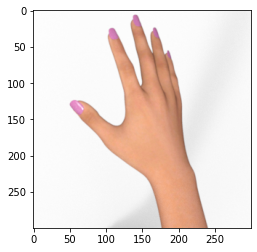

In [40]:
img = Image.open("/content/drive/MyDrive/Rock-Paper-Scissors/test/paper/testpaper01-00.png")
from matplotlib import pyplot as plt
plt.imshow(img)
print(img.size)

In [41]:
class RPSNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    # convolutional layers
    self.conv1 = nn.Conv2d(4, 8, 3, padding=1)
    self.conv2 = nn.Conv2d(8, 16, 3, padding =1)
    self.conv3 = nn.Conv2d(16, 32, 3, padding=1)
    self.conv4 = nn.Conv2d(32, 64, 3, padding=1)
    # linear layers
    self.fc1 = nn.Linear(20736, 1024)
    self.fc2 = nn.Linear(1024, 512)
    self.fc3 = nn.Linear(512, 256)
    self.fc4 = nn.Linear(256, 128)
    self.fc5 = nn.Linear(128, 64)
    self.fc6 = nn.Linear(64, 32)
    self.fc7 = nn.Linear(32, 16)
    self.fc8 = nn.Linear(16, 3) 
    # dropout
    self.dropout = nn.Dropout(p=0.2)
    # max pooling
    self.pool = nn.MaxPool2d(2, 2)
    
  def forward(self, x):
    # convolutional layers with ReLU and pooling
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = self.pool(F.relu(self.conv3(x)))
    x = self.pool(F.relu(self.conv4(x)))
    # flattening the image
    x = x.view(-1, 18*18*64)
    # linear layers
    x = self.dropout(F.relu(self.fc1(x)))
    x = self.dropout(F.relu(self.fc2(x)))
    x = self.dropout(F.relu(self.fc3(x)))
    x = self.dropout(F.relu(self.fc4(x)))
    x = self.dropout(F.relu(self.fc5(x)))
    x = self.dropout(F.relu(self.fc6(x)))
    x = self.dropout(F.relu(self.fc7(x)))
    # x = self.dropout(F.relu(self.fc8(x)))
    x = self.fc8(x)
    x = F.softmax(x)
    return x

In [50]:
model = RPSNetwork()
model = model.cuda()
print(model)

RPSNetwork(
  (conv1): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=20736, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=128, bias=True)
  (fc5): Linear(in_features=128, out_features=64, bias=True)
  (fc6): Linear(in_features=64, out_features=32, bias=True)
  (fc7): Linear(in_features=32, out_features=16, bias=True)
  (fc8): Linear(in_features=16, out_features=3, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)


In [51]:
from torch.optim import Adam

trainLoader = DataLoader(dataset=trainDataset, batch_size=128, shuffle=True)
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr = 0.001)

In [52]:
# epochs to train for
epochs = 25

# tracks validation loss change after each epoch
# minimum_validation_loss = np.inf 

for epoch in range(1, epochs+1):
    
    train_loss = 0
    # valid_loss = 0
    
    # training steps
    model.train()
    correct = 0
    for batch_index, batch in tqdm(enumerate(trainLoader)):
        # moves tensors to GPU
        data, target = batch['input'].float().cuda(), batch['output'].cuda()
        # clears gradients
        optimizer.zero_grad()
        # forward pass
        output = model(data)
        # loss in batch
        loss = criterion(output, target)
        # backward pass for loss gradient
        loss.backward()
        # update paremeters
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        #update accuracy
        for idx, i in enumerate(output):
            i  = torch.argmax(i)
            if i == target[idx]:
                correct += 1
        
    # validation steps
    # model.eval()
    # for batch_index, (data, target) in enumerate(valid_loader):
    #     # moves tensors to GPU
    #     data, target = data.cuda(), target.cuda()
    #     # forward pass
    #     output = model(data)
    #     # loss in batch
    #     loss = criterion(output, target)
    #     # update validation loss
    #     valid_loss += loss.item()*data.size(0)
        
    # average loss calculations
    train_loss = train_loss/len(trainLoader.sampler)
    # valid_loss = valid_loss/len(valid_loader.sampler)
    
    # Display loss statistics
    print(f'Current Epoch: {epoch}\nTraining Loss: {round(train_loss, 6)} \t Accuracy: {round(correct/len(trainLoader.sampler), 6)}')

    # Saving model every time validation loss decreases
    # if valid_loss <= minimum_validation_loss:
        # print(f'Validation loss decreased from {round(minimum_validation_loss, 6)} to {round(valid_loss, 6)}')
torch.save(model.state_dict(), 'trained_model.pt')
# minimum_validation_loss = valid_loss
print('Saving New Model')



0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


1it [00:00,  1.29it/s]

2it [00:01,  1.33it/s]

3it [00:02,  1.35it/s]

4it [00:02,  1.37it/s]

5it [00:03,  1.40it/s]

6it [00:04,  1.41it/s]

7it [00:04,  1.42it/s]

8it [00:05,  1.42it/s]

9it [00:06,  1.43it/s]

10it [00:07,  1.43it/s]

11it [00:07,  1.42it/s]

12it [00:08,  1.43it/s]

13it [00:09,  1.43it/s]

14it [00:09,  1.43it/s]

15it [00:10,  1.43it/s]

16it [00:11,  1.43it/s]

17it [00:11,  1.42it/s]

18it [00:12,  1.42it/s]

19it [00:13,  1.43it/s]

20it [00:13,  1.43it/s]


0it [00:00, ?it/s]

Current Epoch: 1
Training Loss: 1.100564 	 Accuracy: 0.317092




1it [00:00,  1.40it/s]

2it [00:01,  1.39it/s]

3it [00:02,  1.39it/s]

4it [00:02,  1.40it/s]

5it [00:03,  1.41it/s]

6it [00:04,  1.40it/s]

7it [00:04,  1.40it/s]

8it [00:05,  1.41it/s]

9it [00:06,  1.40it/s]

10it [00:07,  1.41it/s]

11it [00:07,  1.42it/s]

12it [00:08,  1.43it/s]

13it [00:09,  1.43it/s]

14it [00:09,  1.43it/s]

15it [00:10,  1.43it/s]

16it [00:11,  1.42it/s]

17it [00:12,  1.41it/s]

18it [00:12,  1.42it/s]

19it [00:13,  1.42it/s]

20it [00:14,  1.42it/s]


0it [00:00, ?it/s]

Current Epoch: 2
Training Loss: 1.008103 	 Accuracy: 0.486444




1it [00:00,  1.41it/s]

2it [00:01,  1.42it/s]

3it [00:02,  1.42it/s]

4it [00:02,  1.41it/s]

5it [00:03,  1.41it/s]

6it [00:04,  1.41it/s]

7it [00:04,  1.42it/s]

8it [00:05,  1.42it/s]

9it [00:06,  1.42it/s]

10it [00:07,  1.42it/s]

11it [00:07,  1.41it/s]

12it [00:08,  1.42it/s]

13it [00:09,  1.42it/s]

14it [00:09,  1.42it/s]

15it [00:10,  1.42it/s]

16it [00:11,  1.41it/s]

17it [00:12,  1.41it/s]

18it [00:12,  1.41it/s]

19it [00:13,  1.41it/s]

20it [00:14,  1.42it/s]


0it [00:00, ?it/s]

Current Epoch: 3
Training Loss: 0.723231 	 Accuracy: 0.824361




1it [00:00,  1.41it/s]

2it [00:01,  1.41it/s]

3it [00:02,  1.42it/s]

4it [00:02,  1.42it/s]

5it [00:03,  1.42it/s]

6it [00:04,  1.42it/s]

7it [00:04,  1.41it/s]

8it [00:05,  1.41it/s]

9it [00:06,  1.40it/s]

10it [00:07,  1.41it/s]

11it [00:07,  1.41it/s]

12it [00:08,  1.41it/s]

13it [00:09,  1.41it/s]

14it [00:09,  1.42it/s]

15it [00:10,  1.40it/s]

16it [00:11,  1.39it/s]

17it [00:12,  1.40it/s]

18it [00:12,  1.41it/s]

19it [00:13,  1.42it/s]

20it [00:14,  1.42it/s]


0it [00:00, ?it/s]

Current Epoch: 4
Training Loss: 0.617835 	 Accuracy: 0.934381




1it [00:00,  1.45it/s]

2it [00:01,  1.44it/s]

3it [00:02,  1.44it/s]

4it [00:02,  1.43it/s]

5it [00:03,  1.43it/s]

6it [00:04,  1.42it/s]

7it [00:04,  1.42it/s]

8it [00:05,  1.42it/s]

9it [00:06,  1.42it/s]

10it [00:07,  1.42it/s]

11it [00:07,  1.42it/s]

12it [00:08,  1.42it/s]

13it [00:09,  1.42it/s]

14it [00:09,  1.42it/s]

15it [00:10,  1.42it/s]

16it [00:11,  1.42it/s]

17it [00:11,  1.43it/s]

18it [00:12,  1.43it/s]

19it [00:13,  1.44it/s]

20it [00:13,  1.43it/s]


0it [00:00, ?it/s]

Current Epoch: 5
Training Loss: 0.563802 	 Accuracy: 0.989784




1it [00:00,  1.38it/s]

2it [00:01,  1.39it/s]

3it [00:02,  1.40it/s]

4it [00:02,  1.41it/s]

5it [00:03,  1.41it/s]

6it [00:04,  1.42it/s]

7it [00:04,  1.42it/s]

8it [00:05,  1.42it/s]

9it [00:06,  1.42it/s]

10it [00:07,  1.43it/s]

11it [00:07,  1.43it/s]

12it [00:08,  1.42it/s]

13it [00:09,  1.43it/s]

14it [00:09,  1.43it/s]

15it [00:10,  1.42it/s]

16it [00:11,  1.41it/s]

17it [00:11,  1.42it/s]

18it [00:12,  1.42it/s]

19it [00:13,  1.42it/s]

20it [00:13,  1.43it/s]


0it [00:00, ?it/s]

Current Epoch: 6
Training Loss: 0.562312 	 Accuracy: 0.989391




1it [00:00,  1.39it/s]

2it [00:01,  1.40it/s]

3it [00:02,  1.41it/s]

4it [00:02,  1.42it/s]

5it [00:03,  1.42it/s]

6it [00:04,  1.43it/s]

7it [00:04,  1.43it/s]

8it [00:05,  1.42it/s]

9it [00:06,  1.43it/s]

10it [00:07,  1.43it/s]

11it [00:07,  1.42it/s]

12it [00:08,  1.42it/s]

13it [00:09,  1.43it/s]

14it [00:09,  1.43it/s]

15it [00:10,  1.43it/s]

16it [00:11,  1.44it/s]

17it [00:11,  1.43it/s]

18it [00:12,  1.43it/s]

19it [00:13,  1.43it/s]

20it [00:13,  1.43it/s]


0it [00:00, ?it/s]

Current Epoch: 7
Training Loss: 0.558229 	 Accuracy: 0.993713




1it [00:00,  1.44it/s]

2it [00:01,  1.44it/s]

3it [00:02,  1.44it/s]

4it [00:02,  1.42it/s]

5it [00:03,  1.42it/s]

6it [00:04,  1.43it/s]

7it [00:04,  1.42it/s]

8it [00:05,  1.42it/s]

9it [00:06,  1.42it/s]

10it [00:07,  1.41it/s]

11it [00:07,  1.42it/s]

12it [00:08,  1.42it/s]

13it [00:09,  1.42it/s]

14it [00:09,  1.42it/s]

15it [00:10,  1.43it/s]

16it [00:11,  1.43it/s]

17it [00:11,  1.41it/s]

18it [00:12,  1.40it/s]

19it [00:13,  1.41it/s]

20it [00:14,  1.43it/s]


0it [00:00, ?it/s]

Current Epoch: 8
Training Loss: 0.567979 	 Accuracy: 0.98389




1it [00:00,  1.41it/s]

2it [00:01,  1.42it/s]

3it [00:02,  1.42it/s]

4it [00:02,  1.42it/s]

5it [00:03,  1.41it/s]

6it [00:04,  1.41it/s]

7it [00:04,  1.41it/s]

8it [00:05,  1.42it/s]

9it [00:06,  1.42it/s]

10it [00:07,  1.42it/s]

11it [00:07,  1.42it/s]

12it [00:08,  1.43it/s]

13it [00:09,  1.42it/s]

14it [00:09,  1.42it/s]

15it [00:10,  1.42it/s]

16it [00:11,  1.42it/s]

17it [00:11,  1.42it/s]

18it [00:12,  1.42it/s]

19it [00:13,  1.43it/s]

20it [00:13,  1.43it/s]


0it [00:00, ?it/s]

Current Epoch: 9
Training Loss: 0.561127 	 Accuracy: 0.99057




1it [00:00,  1.39it/s]

2it [00:01,  1.40it/s]

3it [00:02,  1.41it/s]

4it [00:02,  1.42it/s]

5it [00:03,  1.42it/s]

6it [00:04,  1.42it/s]

7it [00:04,  1.42it/s]

8it [00:05,  1.42it/s]

9it [00:06,  1.42it/s]

10it [00:07,  1.42it/s]

11it [00:07,  1.42it/s]

12it [00:08,  1.42it/s]

13it [00:09,  1.43it/s]

14it [00:09,  1.43it/s]

15it [00:10,  1.43it/s]

16it [00:11,  1.43it/s]

17it [00:11,  1.43it/s]

18it [00:12,  1.43it/s]

19it [00:13,  1.43it/s]

20it [00:13,  1.44it/s]


0it [00:00, ?it/s]

Current Epoch: 10
Training Loss: 0.56689 	 Accuracy: 0.985069




1it [00:00,  1.40it/s]

2it [00:01,  1.39it/s]

3it [00:02,  1.41it/s]

4it [00:02,  1.41it/s]

5it [00:03,  1.41it/s]

6it [00:04,  1.42it/s]

7it [00:04,  1.43it/s]

8it [00:05,  1.43it/s]

9it [00:06,  1.42it/s]

10it [00:07,  1.43it/s]

11it [00:07,  1.43it/s]

12it [00:08,  1.43it/s]

13it [00:09,  1.42it/s]

14it [00:09,  1.43it/s]

15it [00:10,  1.43it/s]

16it [00:11,  1.43it/s]

17it [00:11,  1.43it/s]

18it [00:12,  1.43it/s]

19it [00:13,  1.42it/s]

20it [00:13,  1.43it/s]


0it [00:00, ?it/s]

Current Epoch: 11
Training Loss: 0.561407 	 Accuracy: 0.990177




1it [00:00,  1.43it/s]

2it [00:01,  1.43it/s]

3it [00:02,  1.43it/s]

4it [00:02,  1.43it/s]

5it [00:03,  1.44it/s]

6it [00:04,  1.43it/s]

7it [00:04,  1.42it/s]

8it [00:05,  1.42it/s]

9it [00:06,  1.42it/s]

10it [00:06,  1.43it/s]

11it [00:07,  1.43it/s]

12it [00:08,  1.44it/s]

13it [00:09,  1.43it/s]

14it [00:09,  1.42it/s]

15it [00:10,  1.42it/s]

16it [00:11,  1.40it/s]

17it [00:11,  1.38it/s]

18it [00:12,  1.38it/s]

19it [00:13,  1.38it/s]

20it [00:14,  1.42it/s]


0it [00:00, ?it/s]

Current Epoch: 12
Training Loss: 0.557104 	 Accuracy: 0.994892




1it [00:00,  1.38it/s]

2it [00:01,  1.37it/s]

3it [00:02,  1.38it/s]

4it [00:02,  1.39it/s]

5it [00:03,  1.38it/s]

6it [00:04,  1.39it/s]

7it [00:05,  1.39it/s]

8it [00:05,  1.39it/s]

9it [00:06,  1.38it/s]

10it [00:07,  1.39it/s]

11it [00:07,  1.39it/s]

12it [00:08,  1.39it/s]

13it [00:09,  1.41it/s]

14it [00:10,  1.42it/s]

15it [00:10,  1.42it/s]

16it [00:11,  1.42it/s]

17it [00:12,  1.42it/s]

18it [00:12,  1.42it/s]

19it [00:13,  1.43it/s]

20it [00:14,  1.41it/s]


0it [00:00, ?it/s]

Current Epoch: 13
Training Loss: 0.557108 	 Accuracy: 0.994499




1it [00:00,  1.43it/s]

2it [00:01,  1.43it/s]

3it [00:02,  1.44it/s]

4it [00:02,  1.43it/s]

5it [00:03,  1.42it/s]

6it [00:04,  1.42it/s]

7it [00:04,  1.42it/s]

8it [00:05,  1.43it/s]

9it [00:06,  1.43it/s]

10it [00:07,  1.43it/s]

11it [00:07,  1.42it/s]

12it [00:08,  1.43it/s]

13it [00:09,  1.43it/s]

14it [00:09,  1.43it/s]

15it [00:10,  1.43it/s]

16it [00:11,  1.43it/s]

17it [00:11,  1.43it/s]

18it [00:12,  1.41it/s]

19it [00:13,  1.42it/s]

20it [00:13,  1.43it/s]


0it [00:00, ?it/s]

Current Epoch: 14
Training Loss: 0.555473 	 Accuracy: 0.996071




1it [00:00,  1.39it/s]

2it [00:01,  1.40it/s]

3it [00:02,  1.41it/s]

4it [00:02,  1.42it/s]

5it [00:03,  1.42it/s]

6it [00:04,  1.43it/s]

7it [00:04,  1.43it/s]

8it [00:05,  1.42it/s]

9it [00:06,  1.42it/s]

10it [00:07,  1.42it/s]

11it [00:07,  1.42it/s]

12it [00:08,  1.42it/s]

13it [00:09,  1.42it/s]

14it [00:09,  1.42it/s]

15it [00:10,  1.43it/s]

16it [00:11,  1.42it/s]

17it [00:11,  1.42it/s]

18it [00:12,  1.41it/s]

19it [00:13,  1.42it/s]

20it [00:13,  1.43it/s]


0it [00:00, ?it/s]

Current Epoch: 15
Training Loss: 0.554733 	 Accuracy: 0.996464




1it [00:00,  1.45it/s]

2it [00:01,  1.44it/s]

3it [00:02,  1.44it/s]

4it [00:02,  1.44it/s]

5it [00:03,  1.43it/s]

6it [00:04,  1.43it/s]

7it [00:04,  1.44it/s]

8it [00:05,  1.44it/s]

9it [00:06,  1.44it/s]

10it [00:06,  1.42it/s]

11it [00:07,  1.41it/s]

12it [00:08,  1.43it/s]

13it [00:09,  1.42it/s]

14it [00:09,  1.40it/s]

15it [00:10,  1.40it/s]

16it [00:11,  1.41it/s]

17it [00:11,  1.40it/s]

18it [00:12,  1.40it/s]

19it [00:13,  1.40it/s]

20it [00:14,  1.43it/s]


0it [00:00, ?it/s]

Current Epoch: 16
Training Loss: 0.555636 	 Accuracy: 0.995285




1it [00:00,  1.42it/s]

2it [00:01,  1.43it/s]

3it [00:02,  1.43it/s]

4it [00:02,  1.43it/s]

5it [00:03,  1.42it/s]

6it [00:04,  1.41it/s]

7it [00:04,  1.41it/s]

8it [00:05,  1.42it/s]

9it [00:06,  1.41it/s]

10it [00:07,  1.40it/s]

11it [00:07,  1.38it/s]

12it [00:08,  1.39it/s]

13it [00:09,  1.40it/s]

14it [00:09,  1.40it/s]

15it [00:10,  1.40it/s]

16it [00:11,  1.40it/s]

17it [00:12,  1.40it/s]

18it [00:12,  1.40it/s]

19it [00:13,  1.40it/s]

20it [00:14,  1.42it/s]


0it [00:00, ?it/s]

Current Epoch: 17
Training Loss: 0.554827 	 Accuracy: 0.996464




1it [00:00,  1.43it/s]

2it [00:01,  1.42it/s]

3it [00:02,  1.43it/s]

4it [00:02,  1.43it/s]

5it [00:03,  1.44it/s]

6it [00:04,  1.42it/s]

7it [00:04,  1.42it/s]

8it [00:05,  1.43it/s]

9it [00:06,  1.42it/s]

10it [00:07,  1.43it/s]

11it [00:07,  1.43it/s]

12it [00:08,  1.43it/s]

13it [00:09,  1.42it/s]

14it [00:09,  1.43it/s]

15it [00:10,  1.42it/s]

16it [00:11,  1.43it/s]

17it [00:11,  1.43it/s]

18it [00:12,  1.43it/s]

19it [00:13,  1.42it/s]

20it [00:13,  1.43it/s]


0it [00:00, ?it/s]

Current Epoch: 18
Training Loss: 0.554332 	 Accuracy: 0.99725




1it [00:00,  1.44it/s]

2it [00:01,  1.43it/s]

3it [00:02,  1.43it/s]

4it [00:02,  1.41it/s]

5it [00:03,  1.41it/s]

6it [00:04,  1.42it/s]

7it [00:04,  1.42it/s]

8it [00:05,  1.43it/s]

9it [00:06,  1.41it/s]

10it [00:07,  1.42it/s]

11it [00:07,  1.42it/s]

12it [00:08,  1.42it/s]

13it [00:09,  1.42it/s]

14it [00:09,  1.42it/s]

15it [00:10,  1.41it/s]

16it [00:11,  1.42it/s]

17it [00:11,  1.44it/s]

18it [00:12,  1.44it/s]

19it [00:13,  1.44it/s]

20it [00:13,  1.43it/s]


0it [00:00, ?it/s]

Current Epoch: 19
Training Loss: 0.554594 	 Accuracy: 0.996857




1it [00:00,  1.43it/s]

2it [00:01,  1.41it/s]

3it [00:02,  1.41it/s]

4it [00:02,  1.42it/s]

5it [00:03,  1.42it/s]

6it [00:04,  1.42it/s]

7it [00:04,  1.42it/s]

8it [00:05,  1.43it/s]

9it [00:06,  1.43it/s]

10it [00:07,  1.43it/s]

11it [00:07,  1.43it/s]

12it [00:08,  1.43it/s]

13it [00:09,  1.43it/s]

14it [00:09,  1.43it/s]

15it [00:10,  1.42it/s]

16it [00:11,  1.43it/s]

17it [00:11,  1.43it/s]

18it [00:12,  1.43it/s]

19it [00:13,  1.43it/s]

20it [00:13,  1.43it/s]


0it [00:00, ?it/s]

Current Epoch: 20
Training Loss: 0.555087 	 Accuracy: 0.996464




1it [00:00,  1.43it/s]

2it [00:01,  1.43it/s]

3it [00:02,  1.44it/s]

4it [00:02,  1.43it/s]

5it [00:03,  1.43it/s]

6it [00:04,  1.43it/s]

7it [00:04,  1.44it/s]

8it [00:05,  1.44it/s]

9it [00:06,  1.44it/s]

10it [00:06,  1.44it/s]

11it [00:07,  1.44it/s]

12it [00:08,  1.41it/s]

13it [00:09,  1.42it/s]

14it [00:09,  1.42it/s]

15it [00:10,  1.41it/s]

16it [00:11,  1.41it/s]

17it [00:11,  1.40it/s]

18it [00:12,  1.40it/s]

19it [00:13,  1.41it/s]

20it [00:13,  1.43it/s]


0it [00:00, ?it/s]

Current Epoch: 21
Training Loss: 0.554288 	 Accuracy: 0.99725




1it [00:00,  1.42it/s]

2it [00:01,  1.41it/s]

3it [00:02,  1.41it/s]

4it [00:02,  1.42it/s]

5it [00:03,  1.42it/s]

6it [00:04,  1.42it/s]

7it [00:04,  1.41it/s]

8it [00:05,  1.42it/s]

9it [00:06,  1.41it/s]

10it [00:07,  1.41it/s]

11it [00:07,  1.41it/s]

12it [00:08,  1.41it/s]

13it [00:09,  1.41it/s]

14it [00:09,  1.42it/s]

15it [00:10,  1.42it/s]

16it [00:11,  1.43it/s]

17it [00:11,  1.43it/s]

18it [00:12,  1.43it/s]

19it [00:13,  1.43it/s]

20it [00:14,  1.43it/s]


0it [00:00, ?it/s]

Current Epoch: 22
Training Loss: 0.555379 	 Accuracy: 0.996071




1it [00:00,  1.44it/s]

2it [00:01,  1.44it/s]

3it [00:02,  1.44it/s]

4it [00:02,  1.44it/s]

5it [00:03,  1.44it/s]

6it [00:04,  1.44it/s]

7it [00:04,  1.42it/s]

8it [00:05,  1.43it/s]

9it [00:06,  1.43it/s]

10it [00:07,  1.41it/s]

11it [00:07,  1.42it/s]

12it [00:08,  1.42it/s]

13it [00:09,  1.42it/s]

14it [00:09,  1.42it/s]

15it [00:10,  1.42it/s]

16it [00:11,  1.43it/s]

17it [00:11,  1.43it/s]

18it [00:12,  1.43it/s]

19it [00:13,  1.42it/s]

20it [00:13,  1.43it/s]


0it [00:00, ?it/s]

Current Epoch: 23
Training Loss: 0.554725 	 Accuracy: 0.996857




1it [00:00,  1.42it/s]

2it [00:01,  1.42it/s]

3it [00:02,  1.42it/s]

4it [00:02,  1.42it/s]

5it [00:03,  1.42it/s]

6it [00:04,  1.42it/s]

7it [00:04,  1.43it/s]

8it [00:05,  1.43it/s]

9it [00:06,  1.43it/s]

10it [00:07,  1.43it/s]

11it [00:07,  1.43it/s]

12it [00:08,  1.42it/s]

13it [00:09,  1.42it/s]

14it [00:09,  1.43it/s]

15it [00:10,  1.42it/s]

16it [00:11,  1.42it/s]

17it [00:11,  1.43it/s]

18it [00:12,  1.42it/s]

19it [00:13,  1.42it/s]

20it [00:13,  1.43it/s]


0it [00:00, ?it/s]

Current Epoch: 24
Training Loss: 0.664394 	 Accuracy: 0.886837




1it [00:00,  1.44it/s]

2it [00:01,  1.44it/s]

3it [00:02,  1.45it/s]

4it [00:02,  1.45it/s]

5it [00:03,  1.44it/s]

6it [00:04,  1.44it/s]

7it [00:04,  1.44it/s]

8it [00:05,  1.43it/s]

9it [00:06,  1.43it/s]

10it [00:06,  1.44it/s]

11it [00:07,  1.43it/s]

12it [00:08,  1.43it/s]

13it [00:09,  1.42it/s]

14it [00:09,  1.41it/s]

15it [00:10,  1.40it/s]

16it [00:11,  1.41it/s]

17it [00:11,  1.42it/s]

18it [00:12,  1.42it/s]

19it [00:13,  1.43it/s]

20it [00:13,  1.44it/s]


Current Epoch: 25
Training Loss: 1.124395 	 Accuracy: 0.427112
Saving New Model


In [53]:
torch.save(model.state_dict(), '/content/drive/MyDrive/Rock-Paper-Scissors/trained_model.pt')
print('Saving New Model')

Saving New Model


In [14]:
# EPOCHS = 100
# BATCH_SIZE = 16
# # data_train = DataLoader(dataset = data, batch_size = BATCH_SIZE, shuffle =False)

# for epoch in range(EPOCHS):
#     net.train()
#     epoch_loss = 0
#     correct = 0
#     for bidx, batch in tqdm(enumerate(trainLoader)):
#         x_train, y_train = batch['input'], batch['output']
#         # x_train, y_train = toTensor(x_train), toTensor(y_train)
#         # x_train = x_train.view(-1,8)
#         # print(x_train.size())
#         x_train = x_train.float()
#         x_train = x_train.to(device)
#         y_train = y_train.to(device)
#         loss, predictions = train(net, x_train, y_train, optm, criterion)
#         for idx, i in enumerate(predictions):
#             i  = torch.argmax(i)
#             if i == y_train[idx]:
#                 correct += 1
#         acc = (correct/len(trainDataset))
#         epoch_loss+=loss
#     print('Epoch {} Accuracy : {}'.format(epoch+1, acc*100))
#     print('Epoch {} Loss : {}'.format((epoch+1),epoch_loss))

160it [21:31,  8.07s/it]
0it [00:00, ?it/s]

Epoch 1 Accuracy : 32.73084479371317
Epoch 1 Loss : 196.17051696777344


160it [00:30,  5.20it/s]
1it [00:00,  5.34it/s]

Epoch 2 Accuracy : 33.516699410609036
Epoch 2 Loss : 194.91827392578125


160it [00:30,  5.19it/s]
1it [00:00,  5.28it/s]

Epoch 3 Accuracy : 33.35952848722986
Epoch 3 Loss : 194.20303344726562


160it [00:30,  5.24it/s]
1it [00:00,  5.35it/s]

Epoch 4 Accuracy : 34.22396856581532
Epoch 4 Loss : 193.7828369140625


160it [00:30,  5.23it/s]
1it [00:00,  5.27it/s]

Epoch 5 Accuracy : 34.145383104125735
Epoch 5 Loss : 193.91827392578125


160it [00:30,  5.22it/s]
1it [00:00,  5.31it/s]

Epoch 6 Accuracy : 33.39882121807465
Epoch 6 Loss : 194.20127868652344


160it [00:30,  5.23it/s]
1it [00:00,  5.15it/s]

Epoch 7 Accuracy : 33.47740667976424
Epoch 7 Loss : 193.9642333984375


160it [00:30,  5.22it/s]
1it [00:00,  5.29it/s]

Epoch 8 Accuracy : 34.02750491159136
Epoch 8 Loss : 193.99620056152344


160it [00:30,  5.23it/s]
1it [00:00,  5.38it/s]

Epoch 9 Accuracy : 33.43811394891945
Epoch 9 Loss : 194.89402770996094


160it [00:30,  5.21it/s]
1it [00:00,  5.31it/s]

Epoch 10 Accuracy : 33.713163064833005
Epoch 10 Loss : 194.5780029296875


160it [00:31,  5.15it/s]
1it [00:00,  5.35it/s]

Epoch 11 Accuracy : 34.53831041257367
Epoch 11 Loss : 193.2386932373047


160it [00:30,  5.22it/s]
1it [00:00,  5.29it/s]

Epoch 12 Accuracy : 32.73084479371317
Epoch 12 Loss : 194.98995971679688


160it [00:30,  5.18it/s]
1it [00:00,  5.29it/s]

Epoch 13 Accuracy : 33.63457760314342
Epoch 13 Loss : 194.72604370117188


160it [00:30,  5.22it/s]
1it [00:00,  5.33it/s]

Epoch 14 Accuracy : 32.45579567779961
Epoch 14 Loss : 196.51048278808594


160it [00:30,  5.24it/s]
1it [00:00,  5.36it/s]

Epoch 15 Accuracy : 33.280943025540275
Epoch 15 Loss : 195.3043975830078


160it [00:30,  5.22it/s]
1it [00:00,  5.24it/s]

Epoch 16 Accuracy : 33.1630648330059
Epoch 16 Loss : 195.32106018066406


160it [00:30,  5.23it/s]
0it [00:00, ?it/s]

Epoch 17 Accuracy : 32.73084479371317
Epoch 17 Loss : 196.092529296875


160it [00:30,  5.22it/s]
0it [00:00, ?it/s]

Epoch 18 Accuracy : 33.39882121807465
Epoch 18 Loss : 195.06044006347656


160it [00:30,  5.24it/s]
1it [00:00,  5.26it/s]

Epoch 19 Accuracy : 33.084479371316306
Epoch 19 Loss : 194.62850952148438


160it [00:30,  5.24it/s]
1it [00:00,  5.33it/s]

Epoch 20 Accuracy : 33.79174852652259
Epoch 20 Loss : 194.4393310546875


160it [00:31,  5.14it/s]
0it [00:00, ?it/s]

Epoch 21 Accuracy : 34.22396856581532
Epoch 21 Loss : 193.82640075683594


160it [00:30,  5.22it/s]
1it [00:00,  5.19it/s]

Epoch 22 Accuracy : 32.53438113948919
Epoch 22 Loss : 196.3763427734375


160it [00:30,  5.21it/s]
1it [00:00,  5.39it/s]

Epoch 23 Accuracy : 32.416502946954814
Epoch 23 Loss : 196.6935577392578


160it [00:30,  5.23it/s]
1it [00:00,  5.28it/s]

Epoch 24 Accuracy : 33.90962671905697
Epoch 24 Loss : 193.48692321777344


160it [00:30,  5.23it/s]
1it [00:00,  5.17it/s]

Epoch 25 Accuracy : 34.656188605108056
Epoch 25 Loss : 193.07310485839844


160it [00:30,  5.23it/s]
1it [00:00,  5.34it/s]

Epoch 26 Accuracy : 32.848722986247544
Epoch 26 Loss : 195.8929443359375


160it [00:30,  5.26it/s]
1it [00:00,  5.28it/s]

Epoch 27 Accuracy : 32.45579567779961
Epoch 27 Loss : 195.63050842285156


160it [00:30,  5.24it/s]
1it [00:00,  5.21it/s]

Epoch 28 Accuracy : 33.7524557956778
Epoch 28 Loss : 193.45773315429688


160it [00:30,  5.23it/s]
1it [00:00,  5.25it/s]

Epoch 29 Accuracy : 33.04518664047151
Epoch 29 Loss : 194.7668914794922


160it [00:30,  5.24it/s]
1it [00:00,  5.23it/s]

Epoch 30 Accuracy : 35.717092337917485
Epoch 30 Loss : 191.45152282714844


160it [00:31,  5.15it/s]
1it [00:00,  5.27it/s]

Epoch 31 Accuracy : 33.516699410609036
Epoch 31 Loss : 194.71331787109375


160it [00:30,  5.23it/s]
1it [00:00,  5.26it/s]

Epoch 32 Accuracy : 33.90962671905697
Epoch 32 Loss : 194.233154296875


160it [00:30,  5.20it/s]
1it [00:00,  5.19it/s]

Epoch 33 Accuracy : 32.652259332023576
Epoch 33 Loss : 196.2164764404297


160it [00:30,  5.23it/s]
1it [00:00,  5.36it/s]

Epoch 34 Accuracy : 33.988212180746565
Epoch 34 Loss : 193.1702117919922


160it [00:30,  5.26it/s]
1it [00:00,  5.26it/s]

Epoch 35 Accuracy : 33.35952848722986
Epoch 35 Loss : 194.1554718017578


160it [00:30,  5.23it/s]
1it [00:00,  5.19it/s]

Epoch 36 Accuracy : 32.25933202357564
Epoch 36 Loss : 195.91856384277344


160it [00:30,  5.24it/s]
1it [00:00,  5.35it/s]

Epoch 37 Accuracy : 33.67387033398821
Epoch 37 Loss : 194.7185516357422


160it [00:30,  5.24it/s]
1it [00:00,  5.20it/s]

Epoch 38 Accuracy : 34.77406679764244
Epoch 38 Loss : 192.83416748046875


160it [00:30,  5.27it/s]
1it [00:00,  5.33it/s]

Epoch 39 Accuracy : 32.25933202357564
Epoch 39 Loss : 196.73291015625


160it [00:30,  5.25it/s]
1it [00:00,  5.24it/s]

Epoch 40 Accuracy : 33.7524557956778
Epoch 40 Loss : 193.50088500976562


160it [00:31,  5.15it/s]
0it [00:00, ?it/s]

Epoch 41 Accuracy : 32.73084479371317
Epoch 41 Loss : 196.03939819335938


160it [00:30,  5.23it/s]
1it [00:00,  5.16it/s]

Epoch 42 Accuracy : 33.280943025540275
Epoch 42 Loss : 194.17501831054688


160it [00:30,  5.22it/s]
1it [00:00,  5.32it/s]

Epoch 43 Accuracy : 33.948919449901766
Epoch 43 Loss : 193.3404083251953


160it [00:30,  5.24it/s]
1it [00:00,  5.36it/s]

Epoch 44 Accuracy : 33.83104125736739
Epoch 44 Loss : 193.44076538085938


160it [00:30,  5.26it/s]
1it [00:00,  5.39it/s]

Epoch 45 Accuracy : 33.713163064833005
Epoch 45 Loss : 194.5377655029297


160it [00:30,  5.25it/s]
1it [00:00,  5.27it/s]

Epoch 46 Accuracy : 31.316306483300586
Epoch 46 Loss : 197.28350830078125


160it [00:30,  5.29it/s]
1it [00:00,  5.29it/s]

Epoch 47 Accuracy : 32.92730844793713
Epoch 47 Loss : 195.6319580078125


160it [00:30,  5.24it/s]
1it [00:00,  5.35it/s]

Epoch 48 Accuracy : 32.652259332023576
Epoch 48 Loss : 195.24488830566406


160it [00:30,  5.24it/s]
1it [00:00,  5.32it/s]

Epoch 49 Accuracy : 33.90962671905697
Epoch 49 Loss : 194.21202087402344


160it [00:30,  5.25it/s]
1it [00:00,  5.30it/s]

Epoch 50 Accuracy : 32.4950884086444
Epoch 50 Loss : 196.4423370361328


160it [00:30,  5.24it/s]
0it [00:00, ?it/s]

Epoch 51 Accuracy : 33.1237721021611
Epoch 51 Loss : 194.56454467773438


160it [00:30,  5.17it/s]
1it [00:00,  5.25it/s]

Epoch 52 Accuracy : 33.280943025540275
Epoch 52 Loss : 194.45091247558594


160it [00:30,  5.20it/s]
1it [00:00,  5.12it/s]

Epoch 53 Accuracy : 35.67779960707269
Epoch 53 Loss : 191.289794921875


160it [00:30,  5.25it/s]
1it [00:00,  5.32it/s]

Epoch 54 Accuracy : 31.669941060903735
Epoch 54 Loss : 196.6533966064453


160it [00:30,  5.30it/s]
1it [00:00,  5.22it/s]

Epoch 55 Accuracy : 34.577603143418465
Epoch 55 Loss : 193.2566375732422


160it [00:30,  5.25it/s]
1it [00:00,  5.14it/s]

Epoch 56 Accuracy : 33.20235756385069
Epoch 56 Loss : 195.1429443359375


160it [00:30,  5.25it/s]
1it [00:00,  5.30it/s]

Epoch 57 Accuracy : 33.00589390962672
Epoch 57 Loss : 194.8168182373047


160it [00:30,  5.25it/s]
1it [00:00,  5.27it/s]

Epoch 58 Accuracy : 32.96660117878192
Epoch 58 Loss : 195.66964721679688


160it [00:30,  5.27it/s]
0it [00:00, ?it/s]

Epoch 59 Accuracy : 34.577603143418465
Epoch 59 Loss : 191.9224090576172


160it [00:30,  5.24it/s]
1it [00:00,  5.26it/s]

Epoch 60 Accuracy : 34.49901768172888
Epoch 60 Loss : 193.26278686523438


160it [00:30,  5.27it/s]
1it [00:00,  5.20it/s]

Epoch 61 Accuracy : 33.24165029469548
Epoch 61 Loss : 193.91954040527344


160it [00:31,  5.13it/s]
1it [00:00,  5.32it/s]

Epoch 62 Accuracy : 33.83104125736739
Epoch 62 Loss : 193.2422637939453


160it [00:30,  5.20it/s]
1it [00:00,  5.27it/s]

Epoch 63 Accuracy : 34.18467583497053
Epoch 63 Loss : 193.60997009277344


160it [00:30,  5.24it/s]
1it [00:00,  5.20it/s]

Epoch 64 Accuracy : 34.06679764243615
Epoch 64 Loss : 192.84423828125


160it [00:30,  5.22it/s]
1it [00:00,  5.26it/s]

Epoch 65 Accuracy : 32.141453831041254
Epoch 65 Loss : 197.08035278320312


160it [00:30,  5.24it/s]
1it [00:00,  5.02it/s]

Epoch 66 Accuracy : 33.7524557956778
Epoch 66 Loss : 194.47247314453125


160it [00:30,  5.27it/s]
1it [00:00,  5.31it/s]

Epoch 67 Accuracy : 33.90962671905697
Epoch 67 Loss : 193.8948211669922


160it [00:30,  5.26it/s]
1it [00:00,  5.17it/s]

Epoch 68 Accuracy : 34.3418467583497
Epoch 68 Loss : 193.56689453125


160it [00:30,  5.25it/s]
0it [00:00, ?it/s]

Epoch 69 Accuracy : 33.32023575638507
Epoch 69 Loss : 194.99749755859375


160it [00:30,  5.22it/s]
1it [00:00,  5.34it/s]

Epoch 70 Accuracy : 31.00196463654224
Epoch 70 Loss : 197.67303466796875


160it [00:30,  5.25it/s]
1it [00:00,  5.23it/s]

Epoch 71 Accuracy : 33.555992141453835
Epoch 71 Loss : 193.8033447265625


160it [00:31,  5.15it/s]
1it [00:00,  5.37it/s]

Epoch 72 Accuracy : 35.12770137524558
Epoch 72 Loss : 191.092041015625


160it [00:30,  5.19it/s]
1it [00:00,  5.29it/s]

Epoch 73 Accuracy : 32.53438113948919
Epoch 73 Loss : 196.17987060546875


160it [00:30,  5.25it/s]
1it [00:00,  5.21it/s]

Epoch 74 Accuracy : 31.98428290766208
Epoch 74 Loss : 195.8061065673828


160it [00:30,  5.26it/s]
1it [00:00,  5.33it/s]

Epoch 75 Accuracy : 33.35952848722986
Epoch 75 Loss : 193.74728393554688


160it [00:30,  5.27it/s]
1it [00:00,  5.07it/s]

Epoch 76 Accuracy : 32.37721021611002
Epoch 76 Loss : 196.41441345214844


160it [00:30,  5.24it/s]
1it [00:00,  5.40it/s]

Epoch 77 Accuracy : 34.18467583497053
Epoch 77 Loss : 193.53134155273438


160it [00:30,  5.24it/s]
1it [00:00,  5.16it/s]

Epoch 78 Accuracy : 34.02750491159136
Epoch 78 Loss : 194.02496337890625


160it [00:30,  5.26it/s]
1it [00:00,  5.39it/s]

Epoch 79 Accuracy : 33.713163064833005
Epoch 79 Loss : 193.26382446289062


160it [00:30,  5.25it/s]
1it [00:00,  5.44it/s]

Epoch 80 Accuracy : 32.69155206286837
Epoch 80 Loss : 195.04029846191406


160it [00:30,  5.24it/s]
1it [00:00,  5.18it/s]

Epoch 81 Accuracy : 32.06286836935167
Epoch 81 Loss : 196.9845733642578


160it [00:31,  5.15it/s]
1it [00:00,  5.33it/s]

Epoch 82 Accuracy : 33.555992141453835
Epoch 82 Loss : 193.5811004638672


160it [00:30,  5.23it/s]
1it [00:00,  5.39it/s]

Epoch 83 Accuracy : 33.1237721021611
Epoch 83 Loss : 195.7418670654297


160it [00:30,  5.26it/s]
1it [00:00,  5.29it/s]

Epoch 84 Accuracy : 33.32023575638507
Epoch 84 Loss : 193.96368408203125


160it [00:30,  5.24it/s]
1it [00:00,  5.29it/s]

Epoch 85 Accuracy : 32.652259332023576
Epoch 85 Loss : 196.30250549316406


160it [00:30,  5.23it/s]
0it [00:00, ?it/s]

Epoch 86 Accuracy : 34.06679764243615
Epoch 86 Loss : 192.67034912109375


160it [00:30,  5.24it/s]
1it [00:00,  5.19it/s]

Epoch 87 Accuracy : 33.39882121807465
Epoch 87 Loss : 194.891845703125


160it [00:30,  5.22it/s]
1it [00:00,  5.37it/s]

Epoch 88 Accuracy : 32.96660117878192
Epoch 88 Loss : 194.72442626953125


160it [00:30,  5.30it/s]
1it [00:00,  5.36it/s]

Epoch 89 Accuracy : 33.47740667976424
Epoch 89 Loss : 194.9053497314453


160it [00:30,  5.29it/s]
1it [00:00,  5.24it/s]

Epoch 90 Accuracy : 32.141453831041254
Epoch 90 Loss : 196.73939514160156


160it [00:30,  5.32it/s]
1it [00:00,  5.24it/s]

Epoch 91 Accuracy : 32.88801571709234
Epoch 91 Loss : 194.46200561523438


160it [00:30,  5.18it/s]
0it [00:00, ?it/s]

Epoch 92 Accuracy : 33.24165029469548
Epoch 92 Loss : 194.92225646972656


160it [00:30,  5.25it/s]
1it [00:00,  5.36it/s]

Epoch 93 Accuracy : 33.1630648330059
Epoch 93 Loss : 195.43946838378906


160it [00:30,  5.31it/s]
1it [00:00,  5.44it/s]

Epoch 94 Accuracy : 34.22396856581532
Epoch 94 Loss : 193.41488647460938


160it [00:30,  5.30it/s]
1it [00:00,  5.28it/s]

Epoch 95 Accuracy : 32.4950884086444
Epoch 95 Loss : 196.43861389160156


160it [00:30,  5.28it/s]
1it [00:00,  5.31it/s]

Epoch 96 Accuracy : 32.848722986247544
Epoch 96 Loss : 195.8946075439453


160it [00:30,  5.27it/s]
1it [00:00,  5.17it/s]

Epoch 97 Accuracy : 33.63457760314342
Epoch 97 Loss : 194.6974639892578


160it [00:30,  5.30it/s]
1it [00:00,  5.19it/s]

Epoch 98 Accuracy : 33.63457760314342
Epoch 98 Loss : 194.6033172607422


160it [00:30,  5.32it/s]
1it [00:00,  5.31it/s]

Epoch 99 Accuracy : 33.47740667976424
Epoch 99 Loss : 193.8443145751953


160it [00:30,  5.25it/s]

Epoch 100 Accuracy : 33.04518664047151
Epoch 100 Loss : 195.3923797607422
